Number of detected ROIs: 69
ROI 1 has 1502 pixels.
ROI 2 has 862 pixels.
ROI 3 has 1637 pixels.
ROI 4 has 1768 pixels.
ROI 5 has 1169 pixels.
ROI 6 has 1156 pixels.
ROI 7 has 1484 pixels.
ROI 8 has 1533 pixels.
ROI 9 has 1119 pixels.
ROI 10 has 1455 pixels.
ROI 11 has 981 pixels.
ROI 12 has 1691 pixels.
ROI 13 has 955 pixels.
ROI 14 has 1232 pixels.
ROI 15 has 1727 pixels.
ROI 16 has 957 pixels.
ROI 17 has 1901 pixels.
ROI 18 has 840 pixels.
ROI 19 has 1080 pixels.
ROI 20 has 1319 pixels.
ROI 21 has 925 pixels.
ROI 22 has 1341 pixels.
ROI 23 has 1263 pixels.
ROI 24 has 2072 pixels.
ROI 25 has 1792 pixels.
ROI 26 has 1493 pixels.
ROI 27 has 1770 pixels.
ROI 28 has 1863 pixels.
ROI 29 has 1251 pixels.
ROI 30 has 1621 pixels.
ROI 31 has 1031 pixels.
ROI 32 has 1378 pixels.
ROI 33 has 1147 pixels.
ROI 34 has 1852 pixels.
ROI 35 has 1098 pixels.
ROI 36 has 1761 pixels.
ROI 37 has 1101 pixels.
ROI 38 has 1636 pixels.
ROI 39 has 1128 pixels.
ROI 40 has 1516 pixels.
ROI 41 has 1212 pixels.
ROI

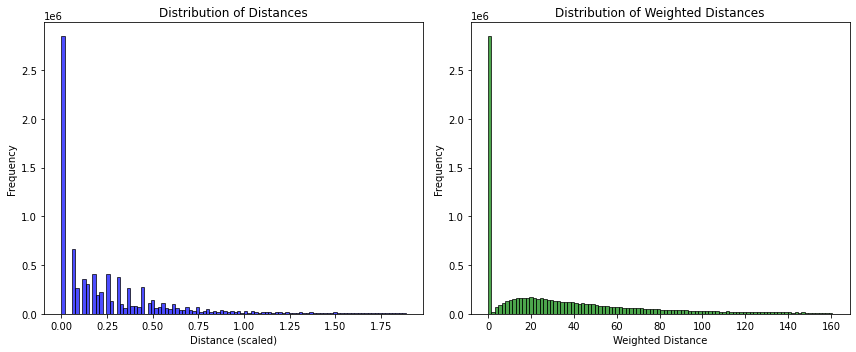

In [14]:
import numpy as np
from skimage import measure
from scipy.spatial import cKDTree
import matplotlib.pyplot as plt
from tifffile import imread

# Define the paths to your images and ROI mask
roi_mask_path = r'C:\Users\sqjac\OneDrive\Desktop\research stuff\DRAD\slices_h_d1_d2_g\Ilya analysis\ROI_mask-D1_10k_B_2.tif'
image1_path = r'C:\Users\sqjac\OneDrive\Desktop\research stuff\DRAD\slices_h_d1_d2_g\Ilya analysis\C1-D1_10k_B_2.tif'
image2_path = r'C:\Users\sqjac\OneDrive\Desktop\research stuff\DRAD\slices_h_d1_d2_g\Ilya analysis\C2-D1_10k_B_2.tif'
OG_image2_path = r'C:\Users\sqjac\OneDrive\Desktop\research stuff\DRAD\slices_h_d1_d2_g\background subtracted\C2-D1_10k_B_2.tif'

# Load images
roi_mask = imread(roi_mask_path)
image1 = imread(image1_path)
image2 = imread(image2_path)
OG_image2 = imread(OG_image2_path)

# Function to calculate radial profile using cKDTree for efficient distance calculation
def protein_nucleoid_distance(image1, image2, roi_mask, scaling_factor=0.06200195312):
    # Convert binary mask to labeled mask with each ROI assigned a unique integer
    labeled_rois = measure.label(roi_mask)
    
    # Get unique labels for ROIs
    unique_labels = np.unique(labeled_rois)
    
    # Exclude background
    unique_labels = unique_labels[unique_labels != 0]  
    num_rois = len(unique_labels)
    print(f"Number of detected ROIs: {num_rois}")  
    
    # Initialize lists to store distances and corresponding values
    list1 = []  # Distances
    list2 = []  # Weighted distances (distance * pixel value in image2)
    
    # Loop through each ROI
    for roi in range(1, num_rois + 1):
        # Isolate pixels in current ROI by creating binary mask where only pixels in current ROI are True
        current_roi_mask = (labeled_rois == roi)
        
        # Count the total number of pixels in the current ROI
        num_pixels_in_roi = np.sum(current_roi_mask)
        print(f"ROI {roi} has {num_pixels_in_roi} pixels.")
        
        # Extract coordinates (row, column) of all pixels in current ROI
        coords = np.column_stack(np.where(current_roi_mask))
        
        # Skip ROI if empty (no coordinates)
        if len(coords) == 0:
            print(f"ROI {roi} is empty.")  
            continue
         
        # Get the coordinates of nonzero pixels in image1 and image2
        nonzero_coords1 = np.column_stack(np.where(image1 > 0))  # Nonzero pixels in image1
        nonzero_coords2 = np.column_stack(np.where(image2 > 0))  # Nonzero pixels in image2
        nonzero_coords2 = np.column_stack(np.where(image2 > 0))  # Nonzero pixels in image2
        
        if len(nonzero_coords1) > 0 and len(nonzero_coords2) > 0:
            # Build a KD-tree for efficient nearest-neighbor search
            tree1 = cKDTree(nonzero_coords1)
            
            # Find the nearest neighbor in image1 for each pixel in image2
            dist, _ = tree1.query(nonzero_coords2)  # dist is the minimum distance to nearest neighbor
            
            # Apply scaling factor to distances
            scaled_dist = dist * scaling_factor
            
            # Store scaled distances and their corresponding pixel values from image2
            list1.extend(scaled_dist)  # Store scaled distances
            list2.extend(scaled_dist * OG_image2[nonzero_coords2[:, 0], nonzero_coords2[:, 1]])  # Store weighted distances
    
    return list1, list2

# Call the function and store the result
list1, list2 = protein_nucleoid_distance(image1, image2, roi_mask, scaling_factor=0.06200195312)

# Print a summary of the results
print("List1 (Distances):", list1[:10], "...")  # Only the first 10 elements
print("List2 (Weighted Distances):", list2[:10], "...")
print(len(list1),len(list2))

# Define the desired range for the histograms
distance_range = (0, np.percentile(list1, 95))
weighted_distance_range = (0, np.percentile(list2, 95))
# Plot histograms of distances and weighted distances
plt.figure(figsize=(12, 5))

# Plot for distances with specified range
plt.subplot(1, 2, 1)
plt.hist(list1, bins=100, range=distance_range, color='blue', edgecolor='black', alpha=0.7)
plt.xlabel('Distance (scaled)')
plt.ylabel('Frequency')
plt.title('Distribution of Distances')

# Plot for weighted distances with specified range
plt.subplot(1, 2, 2)
plt.hist(list2, bins=100, range=weighted_distance_range, color='green', edgecolor='black', alpha=0.7)
plt.xlabel('Weighted Distance')
plt.ylabel('Frequency')
plt.title('Distribution of Weighted Distances')

plt.tight_layout()
plt.show()

In [12]:
# Import statistics library
import numpy as np

# Summary statistics for distances
mean_dist = np.mean(list1)
median_dist = np.median(list1)
std_dist = np.std(list1)

# Summary statistics for weighted distances
mean_weighted_dist = np.mean(list2)
median_weighted_dist = np.median(list2)
std_weighted_dist = np.std(list2)

print("Summary Statistics for Distances (list1):")
print(f"Mean: {mean_dist:.2f}")
print(f"Median: {median_dist:.2f}")
print(f"Standard Deviation: {std_dist:.2f}")

print("\nSummary Statistics for Weighted Distances (list2):")
print(f"Mean: {mean_weighted_dist:.2f}")
print(f"Median: {median_weighted_dist:.2f}")
print(f"Standard Deviation: {std_weighted_dist:.2f}")

# Count the number of zero distances
num_zero_distances = np.count_nonzero(np.array(list1) == 0)

# Print the result
print(f"Number of distances that are zero: {num_zero_distances}")

# Count the number of zero weighted distances
num_zero_weighted_distances = np.count_nonzero(np.array(list2) == 0)

# Print the result
print(f"Number of weighted distances that are zero: {num_zero_weighted_distances}")



Summary Statistics for Distances (list1):
Mean: 0.42
Median: 0.19
Standard Deviation: 0.75

Summary Statistics for Weighted Distances (list2):
Mean: 44.09
Median: 24.51
Standard Deviation: 65.32
Number of distances that are zero: 2845905
Number of weighted distances that are zero: 2845905
